In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [2]:

train_dir = 'live datase1/train/'
test_dir = 'live datase1/test/'



IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)
new_test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 2323 images belonging to 7 classes.
Found 580 images belonging to 7 classes.


In [6]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

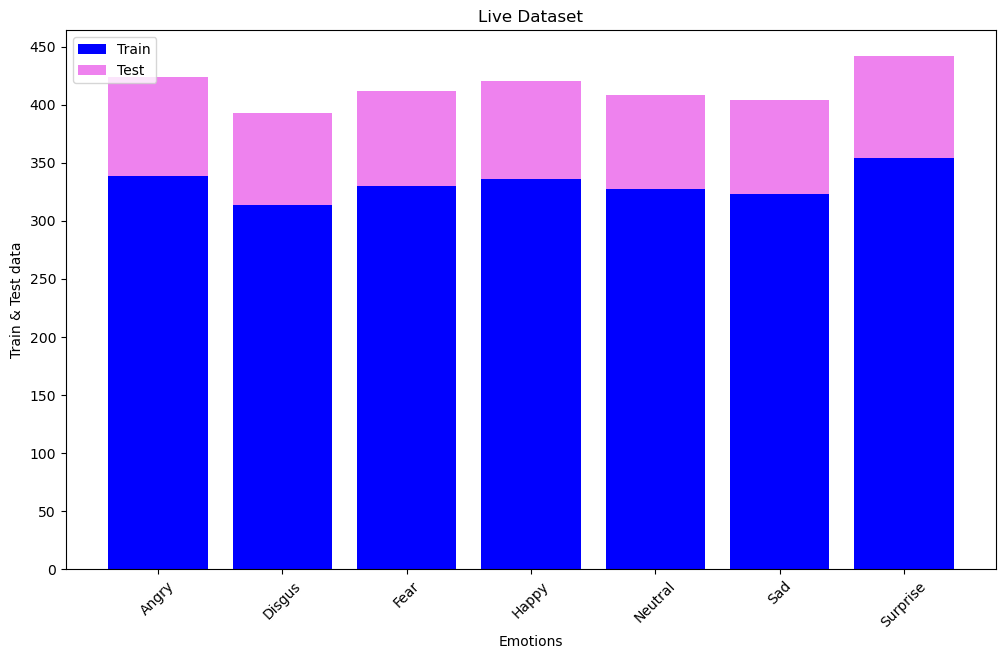

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming you have a mapping of class labels to emotions
class_to_emotion = {
    0: "Angry",
    1: "Disgus",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
    # Add more mappings as needed
}

# Calculate class counts for train and test datasets
train_count = Counter(train_dataset.classes)
test_count = Counter(test_dataset.classes)

# Plot distribution of train/test dataset per class
x = [class_to_emotion[label] for label in test_count.keys()]  # Using emotion names instead of numerical labels
y1 = [train_count[label] for label in test_count.keys()]
y2 = [test_count[label] for label in test_count.keys()]

plt.figure(figsize=(12, 7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("Live Dataset")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed

# Manually set y-axis ticks with gap of 50
plt.yticks(range(0, max(y1) + max(y2) + 50, 50))

plt.savefig('distribution.png')
plt.show()


In [8]:
# Load the model with custom metric function
base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [9]:
# Freezing Layers

for layer in base_model.layers[:11]:
    layer.trainable=False

In [10]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 1, 1, 512)         2048      
 Normalization)                                                  
                                                                 
 gaussian_noise (GaussianNo  (None, 1, 1, 512)         0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [11]:
# Model trainable

print("Model trainable",len(model.trainable_variables))

Model trainable 24


In [12]:

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.legacy.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)


In [ ]:
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model2.h5', save_best_only=True)
es = EarlyStopping(monitor='val_loss', # Monitors the model's validation loss
                               patience=3, # Number of epochs with no improvement after which training will be stopped
                               verbose=1, # Logs when training is stopped
                               restore_best_weights=True)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)



Epoch 1/100


37/37 [==============================] - ETA: 0s - loss: 3.7858 - accuracy: 0.8011 - precision: 0.1520 - recall: 0.0857 - auc: 0.5203 - f1_score: 0.1108 

C:\Users\Abhinav Vannoj\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 627s 17s/step - loss: 3.7858 - accuracy: 0.8011 - precision: 0.1520 - recall: 0.0857 - auc: 0.5203 - f1_score: 0.1108 - val_loss: 5.8914 - val_accuracy: 0.7542 - val_precision: 0.1397 - val_recall: 0.1397 - val_auc: 0.5009 - val_f1_score: 0.1266 - lr: 1.0000e-04
Epoch 2/100
37/37 [==============================] - 596s 16s/step - loss: 3.3892 - accuracy: 0.8099 - precision: 0.2212 - recall: 0.1313 - auc: 0.5997 - f1_score: 0.1640 - val_loss: 8.5807 - val_accuracy: 0.7542 - val_precision: 0.1397 - val_recall: 0.1397 - val_auc: 0.4981 - val_f1_score: 0.1266 - lr: 1.0000e-04
Epoch 3/100
37/37 [==============================] - 2898s 80s/step - loss: 3.1347 - accuracy: 0.8209 - precision: 0.2890 - recall: 0.1739 - auc: 0.6447 - f1_score: 0.2186 - val_loss: 4.0615 - val_accuracy: 0.7542 - val_precision: 0.1397 - val_recall: 0.1397 - val_auc: 0.5747 - val_f1_score: 0.1266 - lr: 1.0000e-04
Epoch 4/100
37/37 [==============================] - ETA: 0s - 

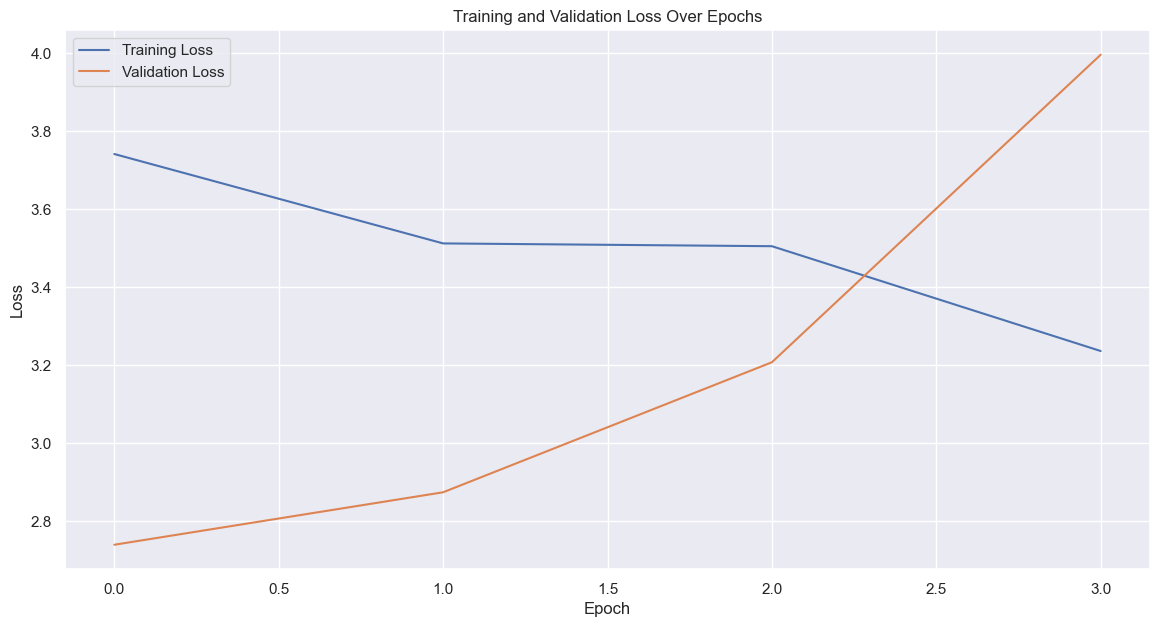

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

3/3 [==============================] - 26s 8s/step - loss: 2.7392 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5012 - f1_score: 0.0000e+00


3/3 [==============================] - 28s 7s/step


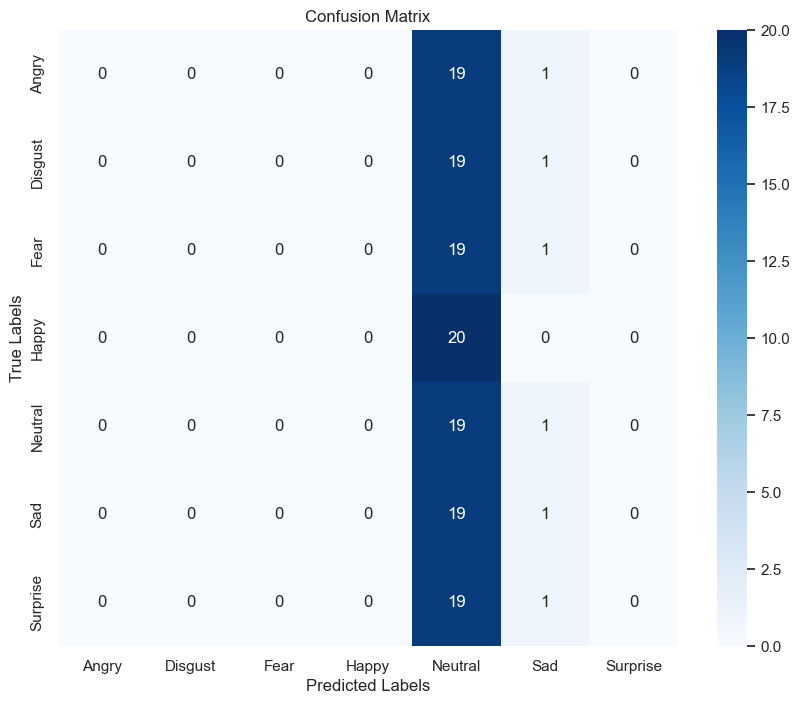

In [25]:
# Get predictions for the test dataset
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels for the test dataset
true_classes = test_dataset.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [22]:
print(test_dataset.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [23]:
from sklearn.metrics import accuracy_score

true_labels = test_dataset.classes

#print(accuracy_score(y_true, y_pred))
cm = tf.math.confusion_matrix(
    true_labels,
    predicted_classes,
    num_classes=len(test_dataset.class_indices)
)

Confusion matrix, without normalization

[[ 0  0  0  0 19  1  0]
 [ 0  0  0  0 19  1  0]
 [ 0  0  0  0 19  1  0]
 [ 0  0  0  0 20  0  0]
 [ 0  0  0  0 19  1  0]
 [ 0  0  0  0 19  1  0]
 [ 0  0  0  0 19  1  0]]




Accuracy: 0.1429

Classification Report:
               precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        20
     Disgust       0.00      0.00      0.00        20
        Fear       0.00      0.00      0.00        20
       Happy       0.00      0.00      0.00        20
     Neutral       0.14      0.95      0.25        20
         Sad       0.17      0.05      0.08        20
    Surprise       0.00      0.00      0.00        20

    accuracy                           0.14       140
   macro avg       0.04      0.14      0.05       140
weighted avg       0.04      0.14      0.05       140



C:\Users\Abhinav Vannoj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Abhinav Vannoj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Abhinav Vannoj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


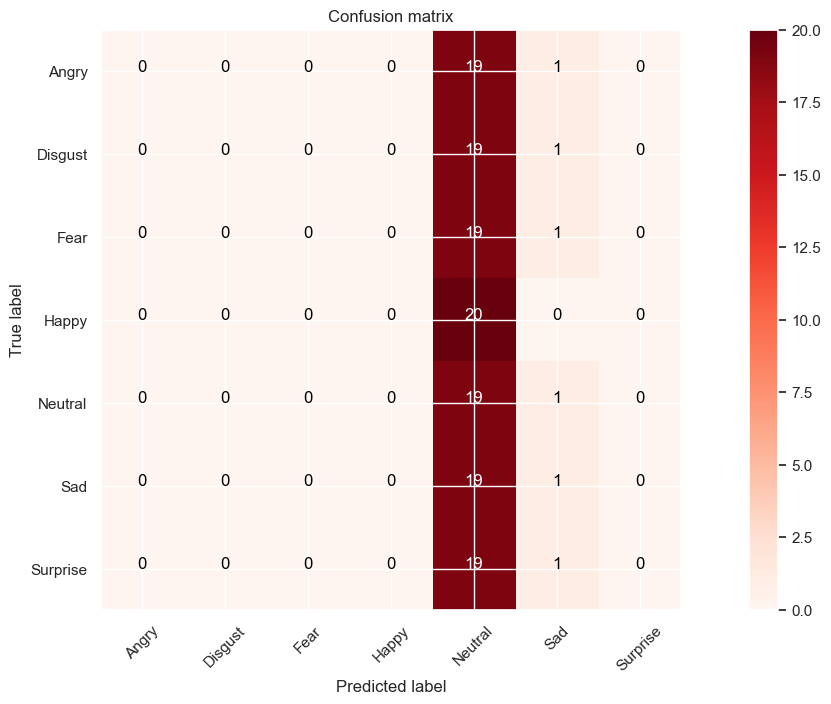

In [24]:
from sklearn.metrics import classification_report, accuracy_score
cm_np = cm.numpy()

plt.rcParams['figure.figsize'] = (14, 7)

# Use seaborn API to set the style
sn.set(style='darkgrid')

plt.imshow(cm_np, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

print('Confusion matrix, without normalization\n')
print(cm_np)

print("\n\n")

accuracy = accuracy_score(true_labels, predicted_classes)
classification_report_str = classification_report(true_labels, predicted_classes, target_names=classes)

print(f'\nAccuracy: {accuracy:.4f}\n')
print('Classification Report:\n', classification_report_str)


thresh = cm_np.max() / 2.
for i, j in itertools.product(range(cm_np.shape[0]), range(cm_np.shape[1])):
    plt.text(j, i, cm_np[i, j],
             horizontalalignment="center",
             color="white" if cm_np[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model2_final.h5")
